In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import EarlyStopping
from keras import models, layers, optimizers

All necessary libraries imported.

In [12]:
# Set the path to data folder
data_folder = '/Users/engr/Downloads/birds525'

train = '/Users/engr/Downloads/birds525/train'

test = '/Users/engr/Downloads/birds525/test'

valid = '/Users/engr/Downloads/birds525/valid'

Initializing the main data.

In [13]:
# Get a list of class names and their corresponding image counts in the training set
class_counts = {}
for class_name in os.listdir(os.path.join(data_folder, train)):
    class_path = os.path.join(data_folder, train, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Sort classes by image count in descending order
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Select the top 3 classes
top_classes = [class_name for class_name, _ in sorted_classes[:3]]

print("Top 3 classes:", top_classes)


Top 3 classes: ['RUFOUS TREPE', 'HOUSE FINCH', 'OVENBIRD']


In [14]:
# Set the path to the new reduced data folder
data_folder = '/Users/engr/Downloads/BIRDS-3'

train = '/Users/engr/Downloads/BIRDS-3/train'

test = '/Users/engr/Downloads/BIRDS-3/test'

valid = '/Users/engr/Downloads/BIRDS-3/valid'

Directing the file path to the new manually reduced data folder.

In [15]:
# Data Augmentation to increase the number of images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    valid,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


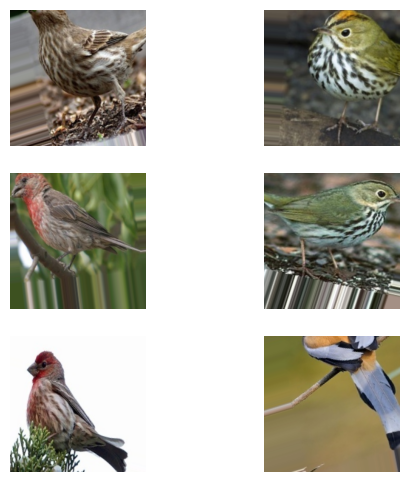

In [16]:
# Displaying first 6 augmented images
image, _ = next(train_generator)
plt.figure(figsize=(6,6))

for i in range(6):
    ax = plt.subplot(3, 2, i+1)
    plt.imshow(image[i])
    plt.axis('off')
plt.show()

Display of few images generated after data augmentation.

In [26]:
# Load pre-trained VGG16 model with imagenet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Display of the pre-trained VGG16 model parameters before freezing the convolutional layers.

In [27]:
# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Display of the pre-trained VGG16 model parameters after freezing the convolutional layers.

In [19]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Compilation of the model with Adams optimizer and loss functions.

Early stopping with low patience included to facilitate the speed of training process 
and also prevent overfitting.

In [20]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25, 
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/25
24/24 [==============================] - 147s 6s/step - loss: 0.8962 - accuracy: 0.5954 - val_loss: 0.2730 - val_accuracy: 1.0000
Epoch 2/25
24/24 [==============================] - 134s 6s/step - loss: 0.4607 - accuracy: 0.8306 - val_loss: 0.0924 - val_accuracy: 1.0000
Epoch 3/25
24/24 [==============================] - 135s 6s/step - loss: 0.3725 - accuracy: 0.8562 - val_loss: 0.0663 - val_accuracy: 1.0000
Epoch 4/25
24/24 [==============================] - 135s 6s/step - loss: 0.3040 - accuracy: 0.8911 - val_loss: 0.0644 - val_accuracy: 1.0000
Epoch 5/25
24/24 [==============================] - 146s 6s/step - loss: 0.2276 - accuracy: 0.9207 - val_loss: 0.0553 - val_accuracy: 1.0000
Epoch 6/25
24/24 [==============================] - 149s 6s/step - loss: 0.2277 - accuracy: 0.9099 - val_loss: 0.0364 - val_accuracy: 1.0000
Epoch 7/25
24/24 [==============================] - 165s 7s/step - loss: 0.1972 - accuracy: 0.9247 - val_loss: 0.0513 - val_accuracy: 1.0000
Epoch 8/25
24

Display of the model training process, as can be seen it stopped at epoch = 12 

due to the early stopping function to prevent overfitting.

It monitors the val_loss and if the next three outputs aren't better than last optimal output,

 the training process stops.

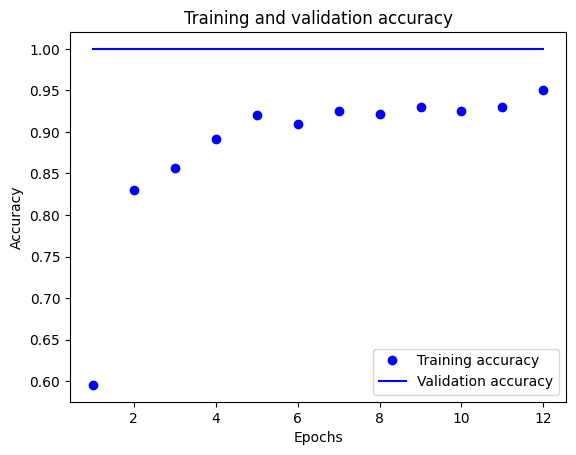

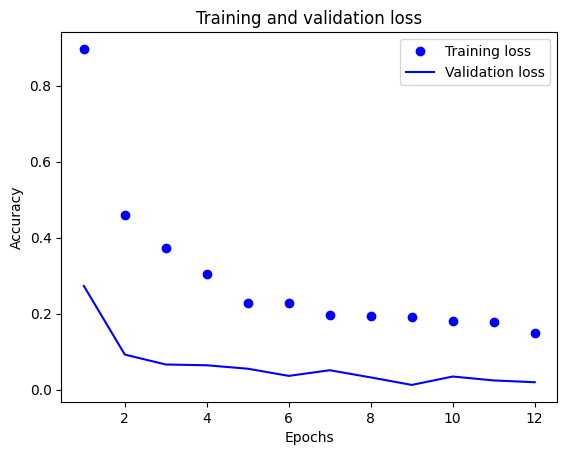

In [21]:
# Accuracy for training and validation
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [22]:
# Evaluate the model on the test set
test_results = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_results[1]}')

# Generate predictions
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
print('\nConfusion Matrix:')
print(conf_matrix)

# Compute classification report
class_report = classification_report(y_true, np.argmax(y_pred, axis=1), target_names=top_classes)
print('\nClassification Report:')
print(class_report)

1/1 [==============================] - 3s 3s/step - loss: 0.0069 - accuracy: 1.0000

Test Accuracy: 1.0
1/1 [==============================] - 3s 3s/step

Confusion Matrix:
[[5 0 0]
 [0 5 0]
 [0 0 5]]

Classification Report:
              precision    recall  f1-score   support

RUFOUS TREPE       1.00      1.00      1.00         5
 HOUSE FINCH       1.00      1.00      1.00         5
    OVENBIRD       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



Test accuracy generated by the model is 100%.

It can also be seen from the confusion matrix that diagonally all the predictions were correct.

AUC for HOUSE FINCH: 1.0
AUC for OVENBIRD: 1.0
AUC for RUFOUS TREPE: 1.0


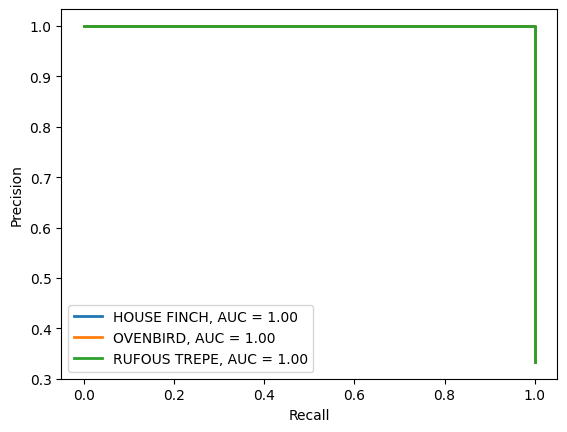

In [23]:
from keras.utils import to_categorical

# convert true labels to one-hot encoding for multi-class
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Since the test accuracy is 100%, there were no misclassified images.